In [72]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import paddle
import torch
import numpy as np
import glob
import os
import random
import cv2
import math

import matplotlib.pyplot as plt

In [3]:
print(paddle.__version__)
print(torch.__version__)

2.0.0
1.8.0


/paddle/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
torch.cuda.device_count()

8

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, ):
        
        self.dataset = np.random.rand(5, 3, 3)
        self.n = len(self.dataset)
        
    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def __len__(self, ):
        return self.n

In [6]:
def collate_fn(samples):
    '''list
    '''
    return samples

In [7]:
dataset = Dataset()

# sampler = torch.utils.data.distributed.DistributedSampler(dataset) if rank != -1 else None

dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, sampler=None)

for i, data in enumerate(dataloader):
    print(data)
    break

In [15]:
def random_perspective(img, targets=(), segments=(), 
                       degrees=10, translate=.1, scale=.1, shear=10, perspective=0.0, border=(0, 0)):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # targets = [cls, xyxy]
    
    height = img.shape[0] + border[0] * 2  # shape(h,w,c)
    width = img.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -img.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -img.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            img = cv2.warpPerspective(img, M, dsize=(width, height), borderValue=(114, 114, 114))
        else:  # affine
            img = cv2.warpAffine(img, M[:2], dsize=(width, height), borderValue=(114, 114, 114))

    # Visualize
    # import matplotlib.pyplot as plt
    # ax = plt.subplots(1, 2, figsize=(12, 6))[1].ravel()
    # ax[0].imshow(img[:, :, ::-1])  # base
    # ax[1].imshow(img2[:, :, ::-1])  # warped

    # Transform label coordinates
    n = len(targets)
    if n:
        use_segments = any(x.any() for x in segments)
        new = np.zeros((n, 4))
        if use_segments:  # warp segments
            segments = resample_segments(segments)  # upsample
            for i, segment in enumerate(segments):
                xy = np.ones((len(segment), 3))
                xy[:, :2] = segment
                xy = xy @ M.T  # transform
                xy = xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]  # perspective rescale or affine

                # clip
                new[i] = segment2box(xy, width, height)

        else:  # warp boxes
            xy = np.ones((n * 4, 3))
            xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
            xy = xy @ M.T  # transform
            xy = (xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]).reshape(n, 8)  # perspective rescale or affine

            # create new boxes
            x = xy[:, [0, 2, 4, 6]]
            y = xy[:, [1, 3, 5, 7]]
            new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

            # clip
            new[:, [0, 2]] = new[:, [0, 2]].clip(0, width)
            new[:, [1, 3]] = new[:, [1, 3]].clip(0, height)

        # filter candidates
        i = box_candidates(box1=targets[:, 1:5].T * s, box2=new.T, area_thr=0.01 if use_segments else 0.10)
        targets = targets[i]
        targets[:, 1:5] = new[i]

    return img, targets


def box_candidates(box1, box2, wh_thr=2, ar_thr=20, area_thr=0.1, eps=1e-16):  # box1(4,n), box2(4,n)
    # Compute candidate boxes: box1 before augment, box2 after augment, wh_thr (pixels), aspect_ratio_thr, area_ratio
    w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
    w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
    ar = np.maximum(w2 / (h2 + eps), h2 / (w2 + eps))  # aspect ratio
    return (w2 > wh_thr) & (h2 > wh_thr) & (w2 * h2 / (w1 * h1 + eps) > area_thr) & (ar < ar_thr)  # candidates


In [77]:
class DatasetYolov5(torch.utils.data.Dataset):
# class DatasetYolov5(paddle.io.Dataset):

    def __init__(self, path, img_size=640, batch_size=8, augment=True, rect=False, stride=32, hyp=None):
        '''
        '''
        
        self.path = path
        self.img_size = img_size
        self.batch_size = batch_size
        self.stride = stride
        self.augment = augment
        self.hyp = hyp
        
        self.rect = rect
        self.mosaic = self.augment and not self.rect
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        
        self.img_files, self.lab_files = self.load_files(path)
        self.n = len(self.img_files)
        self.indices = range(self.n)

        
    def __len__(self, ):
        return self.n
    
    def __getitem__(self, idx):
        
        idx = self.indices[idx]
        
        mosaic = self.mosaic and random.random() < self.hyp['mosaic']
        
        if mosaic:
            img, labels = self.load_mosaic(idx)
        
        return img, labels
            
            
    def load_files(self, path, label=True):
        # load image files
        files = []
        for p in path if isinstance(path, list) else [path, ]:
            files.extend(glob.glob(os.path.join(path, '*.jpg')))
            
        img_files = [os.path.abspath(p) for p in sorted(files)]
        lab_files = [p.replace('/images/', '/labels/').replace('.jpg', '.txt') for p in img_files]
        
        _img_files = []
        _lab_files = []
        
        for im, lab in zip(img_files, lab_files):
            if os.path.exists(im) and os.path.exists(lab):
                _img_files.append(im)
                _lab_files.append(lab)
        
        print(len(_img_files), len(_lab_files))
        # print(_img_files[0], )
        # print(_lab_files[0], )
        
        return _img_files, _lab_files
            
        
    def load_mosaic(self, idx):
        '''load mosaic
        '''
        labels4 = []
        s = self.img_size
        yc, xc = [int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border]  
        indices = [idx] + [self.indices[random.randint(0, self.n - 1)] for _ in range(3)]

        for i, idx in enumerate(indices):
            
            img, _, (h, w) = self.load_image(idx)
            
            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, 3), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b] 
            
            padw = x1a - x1b
            padh = y1a - y1b

            labels = self.load_label(idx)
            if labels.size:
                labels[:, 1:] = self.xywhn2xyxy(labels[:, 1:], w, h, padw, padh)
                
            labels4.append(labels)
            
        labels4 = np.concatenate(labels4, 0)
        for x in labels4[:, 1:]:
            np.clip(x, 0, 2 * s, out=x)
        
        # Augment
        if True:
            img4, labels4 = self.random_perspective(img=img4, targets=labels4,
                                                   degrees=self.hyp['degrees'],
                                                   translate=self.hyp['translate'],
                                                   scale=self.hyp['scale'],
                                                   shear=self.hyp['shear'],
                                                   perspective=self.hyp['perspective'],
                                                   border=self.mosaic_border)  # border to remove

        return img4, labels4
        
            
            
    def load_image(self, index):
        '''load image
        '''
        path = self.img_files[index]
        img = cv2.imread(path)  # BGR
        assert img is not None, 'Image Not Found ' + path
        h0, w0 = img.shape[:2]  # orig hw
        r = self.img_size / max(h0, w0)  # resize image to img_size
        if r != 1:  # always resize down, only resize up if training with augmentation
            interp = cv2.INTER_AREA if r < 1 and not self.augment else cv2.INTER_LINEAR
            img = cv2.resize(img, (int(w0 * r), int(h0 * r)), interpolation=interp)
            
        return img[:,:,::-1], (h0, w0), img.shape[:2]  # img, hw_original, hw_resized
        
        
    def load_label(self, idx):
        '''load label
        '''
        with open(self.lab_files[idx], 'r') as f:
            l = [x.split() for x in f.read().strip().splitlines()]
        return np.array(l, dtype=np.float32)
    
    
    def show(self, idx=None, img=None, bbox=None):
        
        from PIL import Image, ImageDraw
        
        if idx is not None:
            img, bbox = self.__getitem__(idx)
        
        img = Image.fromarray(img)
        draw = ImageDraw.Draw(img)
        
        for i, b in enumerate(bbox):
            draw.rectangle(b[1:], outline='red')
        
        # axes = plt.subplots(1, 2, figsize=(10, 5))
        # plt.imshow(img)
        
        return img
    
    
    @staticmethod
    def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
        # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
        y = np.copy(x)
        y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + padw  # top left x
        y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + padh  # top left y
        y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + padw  # bottom right x
        y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + padh  # bottom right y
        
        return y
    
    
    @staticmethod
    def xywh2xyxy(x):
        # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
        y = np.copy(x)
        y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
        y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
        y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
        y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
        return y


    @staticmethod
    def box_candidates(box1, box2, wh_thr=2, ar_thr=20, area_thr=0.1, eps=1e-16):  # box1(4,n), box2(4,n)
        # Compute candidate boxes: box1 before augment, box2 after augment, wh_thr (pixels), aspect_ratio_thr, area_ratio
        w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
        w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
        ar = np.maximum(w2 / (h2 + eps), h2 / (w2 + eps))  # aspect ratio
        return (w2 > wh_thr) & (h2 > wh_thr) & (w2 * h2 / (w1 * h1 + eps) > area_thr) & (ar < ar_thr)  # candidates

    @staticmethod
    def random_perspective(img, targets=(), segments=(), degrees=10, translate=.1, scale=.1, shear=10, perspective=0.0, border=(0, 0)):
        # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
        # targets = [cls, xyxy]

        height = img.shape[0] + border[0] * 2  # shape(h,w,c)
        width = img.shape[1] + border[1] * 2

        # Center
        C = np.eye(3)
        C[0, 2] = -img.shape[1] / 2  # x translation (pixels)
        C[1, 2] = -img.shape[0] / 2  # y translation (pixels)

        # Perspective
        P = np.eye(3)
        P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
        P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

        # Rotation and Scale
        R = np.eye(3)
        a = random.uniform(-degrees, degrees)
        # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
        s = random.uniform(1 - scale, 1 + scale)
        # s = 2 ** random.uniform(-scale, scale)
        R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

        # Shear
        S = np.eye(3)
        S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
        S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

        # Translation
        T = np.eye(3)
        T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
        T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

        # Combined rotation matrix
        M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
        if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
            if perspective:
                img = cv2.warpPerspective(img, M, dsize=(width, height), borderValue=(114, 114, 114))
            else:  # affine
                img = cv2.warpAffine(img, M[:2], dsize=(width, height), borderValue=(114, 114, 114))

        # Visualize
        # import matplotlib.pyplot as plt
        # ax = plt.subplots(1, 2, figsize=(12, 6))[1].ravel()
        # ax[0].imshow(img[:, :, ::-1])  # base
        # ax[1].imshow(img2[:, :, ::-1])  # warped

        # Transform label coordinates
        n = len(targets)
        if n:
            new = np.zeros((n, 4))
            use_segments = any(x.any() for x in segments)
            xy = np.ones((n * 4, 3))
            xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
            xy = xy @ M.T  # transform
            xy = (xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]).reshape(n, 8)  # perspective rescale or affine

            # create new boxes
            x = xy[:, [0, 2, 4, 6]]
            y = xy[:, [1, 3, 5, 7]]
            new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

            # clip
            new[:, [0, 2]] = new[:, [0, 2]].clip(0, width)
            new[:, [1, 3]] = new[:, [1, 3]].clip(0, height)

            # filter candidates
            i = DatasetYolov5.box_candidates(box1=targets[:, 1:5].T * s, box2=new.T, area_thr=0.01 if use_segments else 0.10)
            targets = targets[i]
            targets[:, 1:5] = new[i]

        return img, targets


In [78]:
hyp = {
    'mosaic': 1.0,
    'mixup': 0.0,
    
    'degrees': 0.0,
    'translate': 0.1,
    'scale': 0.5,
    'shear': 0.0,
    'perspective': 0.0,
    
    'fliplr': 0.5,
    
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4
}
    
dataset = DatasetYolov5(path='../coco/coco/images/val2017/', hyp=hyp)

4952 4952


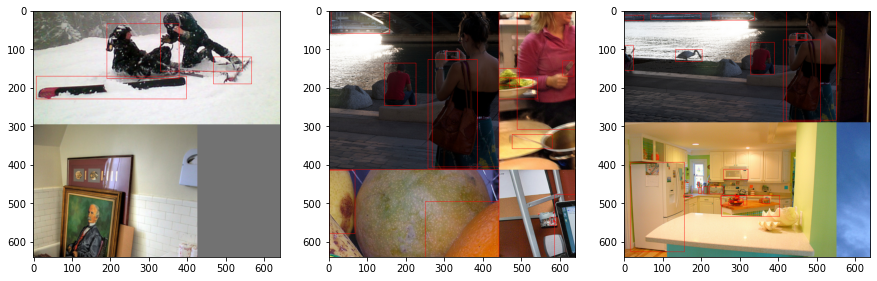

In [79]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    img= dataset.show(10)
    axes[i].imshow(img)

In [91]:
def collate_fn(samples):
    '''list
    '''
    return samples


dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=3, collate_fn=collate_fn)

for data in dataloader:
    
    print(type(data), len(data), type(data[0]), data[0][0].shape, data[0][1].shape)
    
    break

<class 'list'> 8 <class 'tuple'> (640, 640, 3) (12, 5)
